(c)

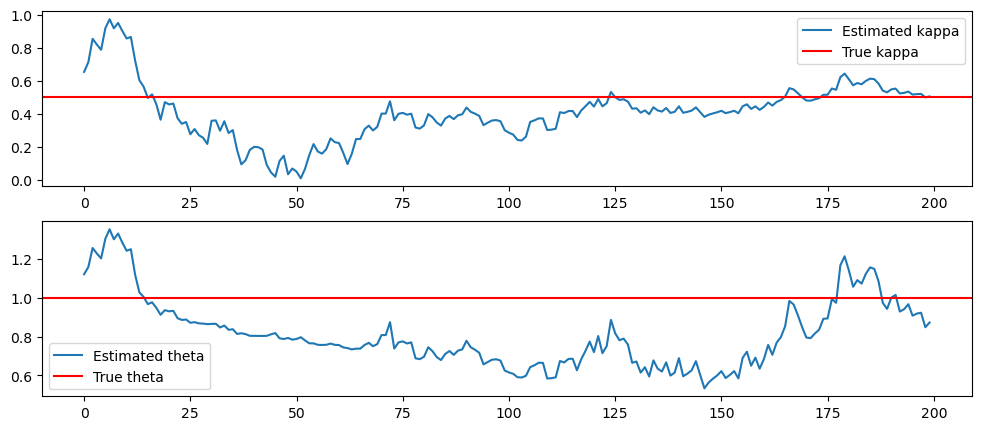

In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

# Define the Jacobian and measurement function as per your provided code
def H_Jacobian(x, dt, St):
    a = (x[1, 0] - St) * dt
    b = x[0, 0] * dt
    return np.array([[a, b]])

def hx(x, dt, St):
    return x[0, 0] * (x[1, 0] - St) * dt

# Define the OU simulation class
class OU_simulation:
    def __init__(self, dt, kappa, theta, St, sigma, n):
        self.kappa = kappa
        self.theta = theta
        self.St = St
        self.dt = dt
        self.sigma = sigma
        self.n = n
        
    def initial_guess(self):
        n_kappa = self.kappa  + .1*randn()
        n_theta = self.theta + .1*randn()
        return np.array([[n_kappa],[n_theta]])
    
    def generate_ou_process(self):
        x = np.zeros(self.n)
        x[0] = self.St
        for i in range(1,self.n):
            dw = np.sqrt(self.dt) * np.random.randn()
            dx = self.kappa * (self.theta - x[i-1]) * self.dt + self.sigma * dw
            x[i] = x[i-1] + dx
        return x

# Define the EKF class
class ExtendedKalmanFilter:
    def __init__(self, F, Q, R):
        self.F = F
        self.Q = Q
        self.R = R
        self.P = np.eye(2)
        self.K = np.zeros((2,1))
    
    def predict(self, x):
        x = np.dot(self.F, x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return x
    
    def update(self, x, z, dt, St):
        H = H_Jacobian(x, dt, St)
        S = np.dot(H, np.dot(self.P, H.T)) + self.R
        self.K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        y = z - hx(x, dt, St)
        x += np.dot(self.K, np.array([[y]]))
        I = np.eye(2)
        self.P = np.dot(I - np.dot(self.K, H), self.P)
        return x

# Simulate the OU process
dt = 0.01
np.random.seed(42)
kappa = 0.5
theta = 1
St = 0.1
sigma = 0.4
ou = OU_simulation(dt, kappa, theta, St, sigma, n=200)
R = 0.4 * dt
Q = np.diag([0.01, 0.01])
F = np.array([[1, 0], [0, 1]])

# Initial guesses
x = ou.initial_guess()
ekf = ExtendedKalmanFilter(F, Q, R)

# Generate the OU process
process = ou.generate_ou_process()

# Apply EKF
kappa_estimates = []
theta_estimates = []
for i in range(len(process)):
    x = ekf.predict(x)
    if i == 0:
        z = process[i]
    else:
        z = process[i] - process[i-1]
    x = ekf.update(x, z, dt, process[i-1])
    kappa_estimates.append(x[0, 0])
    theta_estimates.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(np.arange(len(process)), kappa_estimates, label='Estimated kappa')
plt.axhline(y=ou.kappa, color='r', linestyle='-', label='True kappa')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(len(process)), theta_estimates, label='Estimated theta')
plt.axhline(y=ou.theta, color='r', linestyle='-', label='True theta')
plt.legend()
plt.show()

#### How do you obtain a good estimate of $\sigma$?

We decided to use a l2 loss function that measures the sum of squared residuals between the actual data $\mathbf{s}_t$ and the predicted data $\hat{\mathbf{s}}_t$ generated by the Ornstein-Uhlenbeck process:

$$J(\sigma) = \sum_{t=1}^n(\mathbf{s}_t - \hat{\mathbf{s}}_t)^2.$$

Minimize the objective function $J(\sigma)$ with respect to $\sigma $, while keeping $\kappa $ and $\theta $ fixed at their estimated values from the Extended Kalman Filter (EKF) procedure:

$$\hat{\sigma } = \arg \min_\sigma J(\sigma).$$

Utilize a numerical optimization routine to find the value of $\sigma $ that minimizes $J(\sigma )$, starting from an initial guess $\sigma_0$.

The optimized value $\hat{\sigma }$ obtained from the minimization procedure is taken as the estimated value of $\sigma$.

In [2]:
from scipy.optimize import minimize
import numpy as np

np.random.seed(42)

# Objective function for calibrating sigma
def objective(sigma, data, dt, kappa, theta):
    n = len(data)
    residuals = np.zeros(n-1)
    for i in range(1, n):
        pred = data[i-1] + kappa * (theta - data[i-1]) * dt + sigma * np.sqrt(dt) * np.random.randn()
        residuals[i-1] = data[i] - pred
    return np.sum(residuals**2)

# Calibrate sigma with fixed kappa and theta
def calibrate_sigma(data, dt, kappa, theta):
    initial_guess = [0.39]
    result = minimize(objective, initial_guess, args=(data, dt, kappa, theta))
    return result.x[0]

# Generate the OU process
process = ou.generate_ou_process()

# Parameters from EKF
kappa_est = kappa_estimates[-1]  # Take the last estimate as the representative value
theta_est = theta_estimates[-1]  # Take the last estimate as the representative value

# Calibrate sigma with fixed kappa and theta
sigma_cal = calibrate_sigma(process, dt, kappa_est, theta_est)

# Output
print(f"True Sigma: {ou.sigma}")
print(f"Calibrated Sigma: {sigma_cal}")

True Sigma: 0.4
Calibrated Sigma: 0.39


(d)

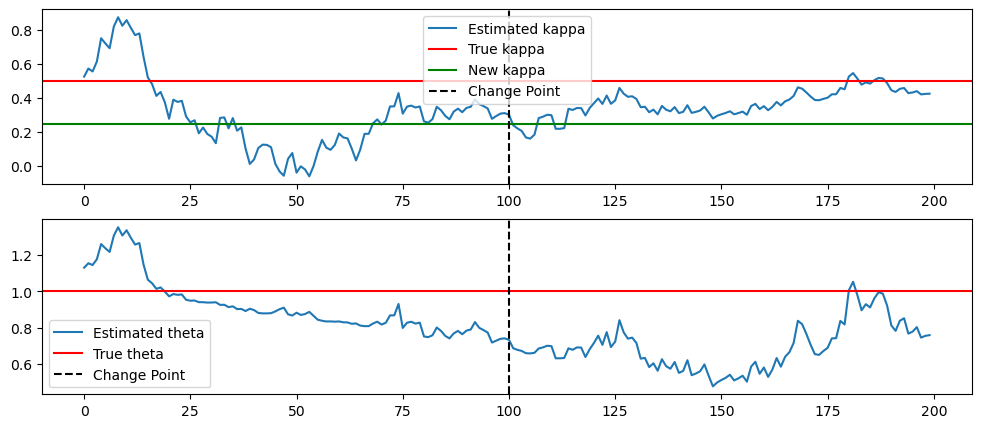

In [3]:
np.random.seed(42)

class OU_simulation_changing_kappa(OU_simulation):
    def __init__(self, change_point, new_kappa, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.change_point = change_point
        self.new_kappa = new_kappa

    def generate_ou_process(self):
        x = np.zeros(self.n)
        x[0] = self.St
        for i in range(1, self.n):
            dw = np.sqrt(self.dt) * np.random.randn()
            if i >= self.change_point:
                kappa = self.new_kappa
            else:
                kappa = self.kappa
            dx = kappa * (self.theta - x[i-1]) * self.dt + self.sigma * dw
            x[i] = x[i-1] + dx
        return x

# Simulate the OU process with changing kappa
change_point = 100  # Index at which kappa changes
new_kappa = kappa/2  # New value of kappa
ou_changing = OU_simulation_changing_kappa(change_point, new_kappa, dt, kappa, theta, St, sigma, n=200)
process_changing = ou_changing.generate_ou_process()

# Reset the initial guesses and EKF
x = ou.initial_guess()
ekf = ExtendedKalmanFilter(F, Q, R)

# Apply EKF on the new process
kappa_estimates_changing = []
theta_estimates_changing = []
for i in range(len(process_changing)):
    x = ekf.predict(x)
    if i == 0:
        z = process_changing[i]
    else:
        z = process_changing[i] - process_changing[i-1]
    x = ekf.update(x, z, dt, process_changing[i-1])
    kappa_estimates_changing.append(x[0, 0])
    theta_estimates_changing.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(np.arange(len(process_changing)), kappa_estimates_changing, label='Estimated kappa')
plt.axhline(y=kappa, color='r', linestyle='-', label='True kappa')
plt.axhline(y=new_kappa, color='g', linestyle='-', label='New kappa')  # New line for new_kappa
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(len(process_changing)), theta_estimates_changing, label='Estimated theta')
plt.axhline(y=theta, color='r', linestyle='-', label='True theta')
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.show()

####  Speeding up the adjustment

Method 1: Increading the observed noise R.

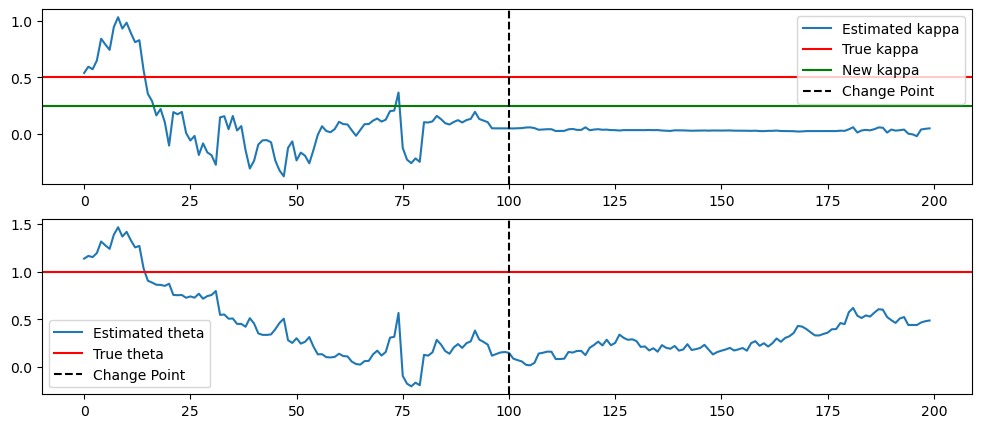

In [4]:
np.random.seed(42)

class OU_simulation_changing_kappa(OU_simulation):
    def __init__(self, change_point, new_kappa, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.change_point = change_point
        self.new_kappa = new_kappa

    def generate_ou_process(self):
        x = np.zeros(self.n)
        x[0] = self.St
        for i in range(1, self.n):
            dw = np.sqrt(self.dt) * np.random.randn()
            if i >= self.change_point:
                kappa = self.new_kappa
            else:
                kappa = self.kappa
            dx = kappa * (self.theta - x[i-1]) * self.dt + self.sigma * dw
            x[i] = x[i-1] + dx
        return x

# Simulate the OU process with changing kappa
change_point = 100  # Index at which kappa changes
new_kappa = kappa/2  # New value of kappa
ou_changing = OU_simulation_changing_kappa(change_point, new_kappa, dt, kappa, theta, St, sigma, n=200)
process_changing = ou_changing.generate_ou_process()

# Reset the initial guesses and EKF
x = ou.initial_guess()
Q_faster = Q = np.diag([0.1, 0.1])
ekf = ExtendedKalmanFilter(F, Q_faster, R)

# Apply EKF on the new process
kappa_estimates_changing = []
theta_estimates_changing = []
for i in range(len(process_changing)):
    x = ekf.predict(x)
    if i == 0:
        z = process_changing[i]
    else:
        z = process_changing[i] - process_changing[i-1]
    x = ekf.update(x, z, dt, process_changing[i-1])
    kappa_estimates_changing.append(x[0, 0])
    theta_estimates_changing.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(np.arange(len(process_changing)), kappa_estimates_changing, label='Estimated kappa')
plt.axhline(y=kappa, color='r', linestyle='-', label='True kappa')
plt.axhline(y=new_kappa, color='g', linestyle='-', label='New kappa')  # New line for new_kappa
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(len(process_changing)), theta_estimates_changing, label='Estimated theta')
plt.axhline(y=theta, color='r', linestyle='-', label='True theta')
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.show()

Method 2: Adaptive EKF, i.e., employ an adaptive filtering technique where the process and measurement noise covariances (Q and R) are updated dynamically based on the innovations (the differences between predicted and actual measurements).

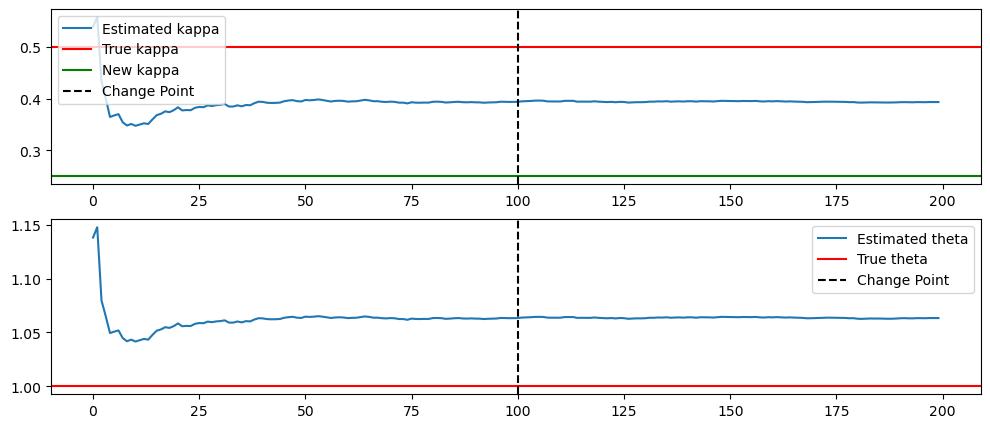

In [5]:
np.random.seed(42)

class AdaptiveExtendedKalmanFilter(ExtendedKalmanFilter):
    def update(self, x, z, dt, St):
        H = H_Jacobian(x, dt, St)
        S = np.dot(H, np.dot(self.P, H.T)) + self.R
        self.K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        y = z - hx(x, dt, St)
        # Adaptive update of Q and R based on innovation
        self.R = (1 - self.K[0, 0]) * self.R + self.K[0, 0] * y**2
        self.Q = self.Q + np.outer(self.K, self.K) * y**2  # Corrected line
        x += np.dot(self.K, np.array([[y]]))
        I = np.eye(2)
        self.P = np.dot(I - np.dot(self.K, H), self.P)
        return x

# Simulate the OU process with changing kappa
change_point = 100  # Index at which kappa changes
new_kappa = kappa/2  # New value of kappa
ou_changing = OU_simulation_changing_kappa(change_point, new_kappa, dt, kappa, theta, St, sigma, n=200)
process_changing = ou_changing.generate_ou_process()

# Reset the initial guesses and EKF
x = ou.initial_guess()
aekf = AdaptiveExtendedKalmanFilter(F, Q, R)  # Using Adaptive EKF

# Apply EKF on the new process
kappa_estimates_changing = []
theta_estimates_changing = []
for i in range(len(process_changing)):
    x = aekf.predict(x)
    if i == 0:
        z = process_changing[i]
    else:
        z = process_changing[i] - process_changing[i-1]
    x = aekf.update(x, z, dt, process_changing[i-1])
    kappa_estimates_changing.append(x[0, 0])
    theta_estimates_changing.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(np.arange(len(process_changing)), kappa_estimates_changing, label='Estimated kappa')
plt.axhline(y=kappa, color='r', linestyle='-', label='True kappa')
plt.axhline(y=new_kappa, color='g', linestyle='-', label='New kappa')  # New line for new_kappa
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(len(process_changing)), theta_estimates_changing, label='Estimated theta')
plt.axhline(y=theta, color='r', linestyle='-', label='True theta')
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.show()

It seems that adaptive EKF works a bit more harder for current cituation.

Method 3: Resetting EKF: reset the filter state and covariance matrix whenever a significant change is detected. One simple change detection method could be to monitor the residuals (innovations) and reset the filter when a large residual is observed.

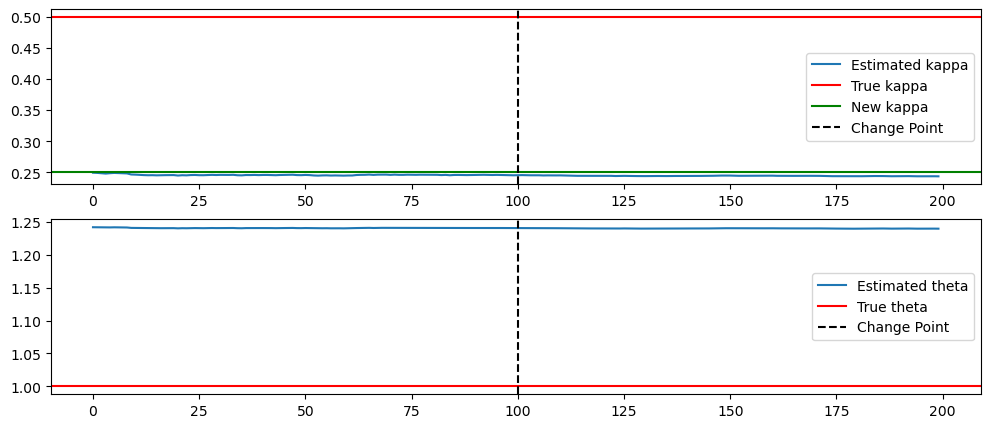

In [6]:
class ResettingExtendedKalmanFilter(ExtendedKalmanFilter):
    def update(self, x, z, dt, St):
        H = H_Jacobian(x, dt, St)
        S = np.dot(H, np.dot(self.P, H.T)) + self.R
        self.K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        y = z - hx(x, dt, St)
        # Reset filter if large residual is observed
        if np.abs(y) > 0.1:  # Threshold may need to be tuned
            self.P = np.eye(2)
        x += np.dot(self.K, np.array([[y]]))
        I = np.eye(2)
        self.P = np.dot(I - np.dot(self.K, H), self.P)
        return x

# Simulate the OU process with changing kappa
change_point = 100  # Index at which kappa changes
new_kappa = kappa/2  # New value of kappa
ou_changing = OU_simulation_changing_kappa(change_point, new_kappa, dt, kappa, theta, St, sigma, n=200)
process_changing = ou_changing.generate_ou_process()

# Reset the initial guesses and EKF
x = ou.initial_guess()
rekf = ResettingExtendedKalmanFilter(F, Q, R)  # Using Resetting EKF

for i in range(len(process_changing)):
    x = rekf.predict(x)
    if i == 0:
        z = process_changing[i]
    else:
        z = process_changing[i] - process_changing[i-1]
    x = rekf.update(x, z, dt, process_changing[i-1])
    kappa_estimates_changing.append(x[0, 0])
    theta_estimates_changing.append(x[1, 0])

# Apply EKF on the new process
kappa_estimates_changing = []
theta_estimates_changing = []
for i in range(len(process_changing)):
    x = aekf.predict(x)
    if i == 0:
        z = process_changing[i]
    else:
        z = process_changing[i] - process_changing[i-1]
    x = aekf.update(x, z, dt, process_changing[i-1])
    kappa_estimates_changing.append(x[0, 0])
    theta_estimates_changing.append(x[1, 0])

# Plotting the results
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(np.arange(len(process_changing)), kappa_estimates_changing, label='Estimated kappa')
plt.axhline(y=kappa, color='r', linestyle='-', label='True kappa')
plt.axhline(y=new_kappa, color='g', linestyle='-', label='New kappa')  # New line for new_kappa
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.arange(len(process_changing)), theta_estimates_changing, label='Estimated theta')
plt.axhline(y=theta, color='r', linestyle='-', label='True theta')
plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
plt.legend()
plt.show()

It seems that resetting EKF works a lot more harder for current cituation.

By comparing the above three possible speeding up method, we need to be aware that speeding up is actually a speed and precision trade-off problem.